# how to construct yield curves by bootstrapping bond quotes.

In [1]:
import QuantLib as ql 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

plt.style.use('bmh')

In [2]:
# given rate and maturity

# deposit rates
depo_maturities = [ql.Period(6, ql.Months), ql.Period(12, ql.Months)]
depo_rates = [5.25, 5.5]

# bond rates
bond_maturities = [ql.Period(6*i, ql.Months) for i in range(3, 21)]
bond_rates = [5.75, 6.0, 6.25, 6.5, 6.75, 6.80, 7.00, 7.1, 7.15, 
              7.2, 7.3, 7.35, 7.4, 7.5, 7.6, 7.6, 7.7, 7.8]

In [3]:
# combine together

maturities = depo_maturities + bond_maturities
rates = depo_rates + bond_rates

In [4]:
pd.DataFrame(data={'Maturities':maturities, 'Curve':rates})

,Maturities,Curve
0,6M,5.25
1,1Y,5.50
2,1Y6M,5.75
3,2Y,6.00
4,2Y6M,6.25
5,3Y,6.50
6,3Y6M,6.75
7,4Y,6.80
8,4Y6M,7.00
9,5Y,7.10


In [5]:
# set calculation date

calc_date = ql.Date(1, ql.January, 2022)
ql.Settings.instance().evaluationDate = calc_date

In [6]:
# set arguments

calendar = ql.UnitedStates()
business_convention = ql.Unadjusted
day_count = ql.Thirty360()
end_of_month = True
settlement_days = 0
face_amount = 100
coupon_frequency = ql.Period(ql.Semiannual)

In [7]:
# deposit rate helpers for all rate, maturity

depo_helpers = [
    ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r/100)),
                         m,
                         settlement_days,
                         calendar,
                         business_convention,
                         end_of_month, 
                         day_count)
    for r, m in zip(depo_rates, depo_maturities)
]

In [8]:
# bond helpers assume that coupon == YTM

bond_helpers = []

for r, m in zip(bond_rates, bond_maturities):
    
    # maturity date
    termination_date = calc_date + m 
    
    # payment schedule
    schedule = ql.Schedule(calc_date,
                           termination_date,
                           coupon_frequency, 
                           calendar,
                           business_convention,
                           business_convention,
                           ql.DateGeneration.Backward,
                           end_of_month)
    
    bond_helper = ql.FixedRateBondHelper(ql.QuoteHandle(ql.SimpleQuote(face_amount)),
                                         settlement_days,
                                         face_amount,
                                         schedule,
                                         [r/100], # coupon
                                         day_count,
                                         business_convention)
    
    bond_helpers.append(bond_helper)

In [9]:
# combine together

rate_helpers = depo_helpers + bond_helpers

In [10]:
# get yield curve
# using "LogCubic" interpolation of the Discount factor
yield_curve = ql.PiecewiseLogCubicDiscount(calc_date,
                                           rate_helpers,
                                           day_count)

In [11]:
# get monthly spot rates
# 10-years --> 12*10 = 120
# +1 for time 0 --> 121

n_months = 121
spots = []
tenors = []
ref_date = yield_curve.referenceDate()

for month in range(n_months):
    # convert month to year
    yrs = month / 12
    tenors.append(yrs)
    
    # get spot rate
    d = calendar.advance(ref_date, ql.Period(month, ql.Months))
    compounding = ql.Compounded
    freq = ql.Semiannual
    zero_rate = yield_curve.zeroRate(yrs, compounding, freq)
    eq_rate = zero_rate.equivalentRate(day_count,
                                       compounding,
                                       freq,
                                       ref_date,
                                       d).rate()
    spots.append(eq_rate * 100)

In [12]:
yc_df = pd.DataFrame(data={'Maturities':tenors, 'Curve':spots})
yc_df

,Maturities,Curve
0,0.000000,5.210390
1,0.083333,5.211455
2,0.166667,5.214647
3,0.250000,5.219969
4,0.333333,5.227420
...,...,...
116,9.666667,7.979328
117,9.750000,8.003230
118,9.833333,8.026079
119,9.916667,8.048116


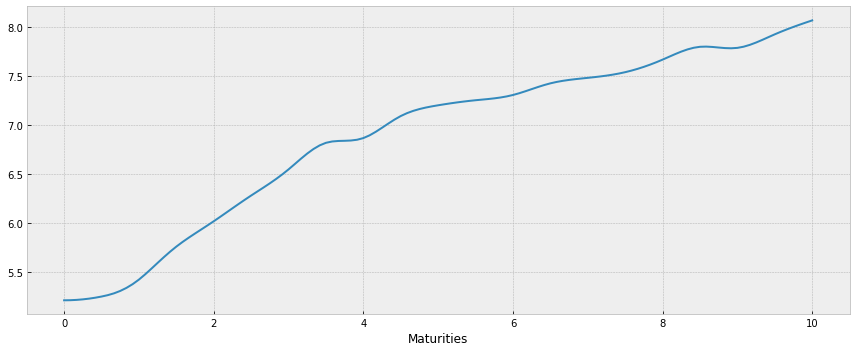

In [13]:
yc_df.plot('Maturities', 'Curve', figsize=(12,5), legend=False)
plt.tight_layout()
plt.show()